# Домашняя работа №1. Часть №2. Оптимальные портфели инвестиций.

 <b>рынок:</b> Бразилия<br>
 <b>период:</b> 2018 год

In [33]:
# Библиотеки и считывание данных
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize

# Считываем данные из файла
data = pd.read_csv("..\data_log_return.csv")
tickers = list(data.columns)
tickers.pop(0)

'Date'

# 1. Portfolio with minimal risk.
- Выбрать на рынке набор из 50 активов. Объясните ваш выбор.
- вычислите портфель с минимальным риском с разрешением коротких продаж.
- вычислите портфель с минимальным риском с запретом коротких продаж.
- сравните оба портфеля и опишите различие между ними (если есть). Отметьте оба портфеля на
карте активов в системе координат (σ, E).


In [230]:
# Вычисление оценки ожидаемых доходностей и стандартных отклонений
def find_E_n_sigma(data, tickers):
    expected_returns = {}
    risks = {}

    for ticker in tickers:
        risk = data[ticker].std()
        expected_returns[ticker] = data[ticker].mean()
        risks[ticker] = risk

    risk_and_return = pd.DataFrame({
        'Ticker': expected_returns.keys(),
        'E': expected_returns.values(),
        'σ': risks.values()
    })

    return risk_and_return

In [231]:
# Функция для поиска Парето-оптимальных активов

def find_pareto_optimal(portfolio):
    pareto_optimal_assets = []

    assets = list(portfolio['Ticker'])
    portfolio_ = find_E_n_sigma(data, assets)

    E_values = np.array(list(portfolio_['E']))
    Sigma_values = np.array(list(portfolio_['σ']))

    for i in range(len(assets)):
        current_E = E_values[i]
        current_Sigma = Sigma_values[i]
        is_optimal = True
        for j in range(len(assets)):
            if i != j:
                if (E_values[j] >= current_E and Sigma_values[j] <= current_Sigma):
                    is_optimal = False
                    break
        if is_optimal:
            pareto_optimal_assets.append(assets[i])

    return pareto_optimal_assets


<p>Итак, используя данные о 567 компаниях, отобранных в предыдущем шаге, мы начали отбор 50 активов. Для этого мы нашли все парето-оптимальные активы.

In [262]:
risk_and_return = find_E_n_sigma(data, tickers)
pareto_optimal_assets = find_pareto_optimal(risk_and_return)
pareto_optimal = find_E_n_sigma(data, pareto_optimal_assets)

print(pareto_optimal)

      Ticker         E         σ
0   AZEV3.SA  0.005261  0.089274
1   CEGR3.SA  0.000819  0.008155
2   CPFE3.SA  0.001613  0.012433
3   EQPA6.SA  0.011053  0.094818
4   HETA3.SA  0.000010  0.000160
5   IRBR3.SA  0.003700  0.017212
6  LILY34.SA  0.001648  0.016880
7   LOGN3.SA  0.003912  0.045399
8  MRCK34.SA  0.001626  0.015278
9  NPAR11.SA  0.000408  0.002748


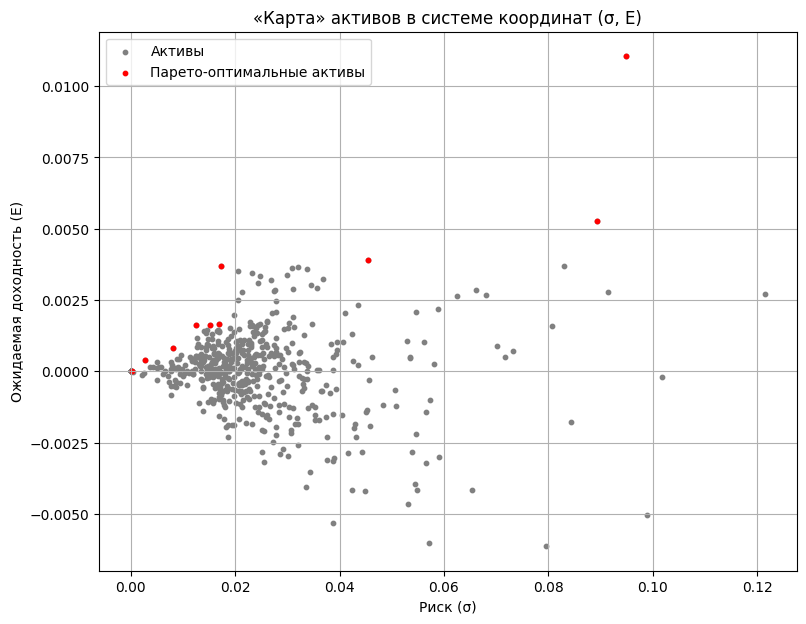

In [233]:
# Построение карты активов в системе координат (σ, E)
plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(pareto_optimal['σ'], pareto_optimal['E'], s=10, color='red', label='Парето-оптимальные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

У нас получилось 11 Парето-оптимальных активов (Веделены красным цветом). Оставшиеся 39 выбрали из следующих соображений: нашли корреляционную матрицу и отобрали активы, которые имеют наименьшую корреляцию с парето-оптимальными активами, положительную доходность и минимальный риск для диверсификации портфеля. 

In [234]:
to_find = 50 - len(pareto_optimal_assets)

'''_______________________________________________________________________________________

Рассчитываем Z-оценку для стандартных отклонений log_returns для каждого актива.
И фильтруем активы с  Z-оценкой, превышающими заданный порог (в данном случае 3), чтобы уменьшить влияние выбросов.
_______________________________________________________________________________________'''

E_dict = {}
Sigma_dict = {}

for ticker in tickers:
    risk = data[ticker].std()
    E_dict[ticker] = data[ticker].mean()
    Sigma_dict[ticker] = risk

E_values = np.array(list(E_dict.values()))
Sigma_values = np.array(list(Sigma_dict.values()))

z_scores = np.abs(stats.zscore(Sigma_values))
threshold = 3
filtered_Sigma_values = Sigma_values[(z_scores < threshold)]
filtered_E_values = E_values[(z_scores < threshold)]
filtered_assets = np.array(tickers)[(z_scores < threshold)]

correlation_matrix = data.pivot_table(index='Date').corr()

selected_tickers = []

selected_tickers.extend(pareto_optimal_assets)

'''_______________________________________________________________________________________

Цель этих циклов - обеспечить отбор достаточного количества активов, начиная с тех, которые наименее коррелируют с Парето-оптимальными активами,
а затем, при необходимости, с теми, которые наиболее коррелируют.

Этот подход направлен на диверсификацию ассортимента при одновременном обеспечении положительной ожидаемой доходности выбранных активов.
______________________________________________________________________________________'''


added_assets = 0
for asset in pareto_optimal_assets:
    correlations = correlation_matrix[asset]
    sorted_correlations = correlations.sort_values(ascending=True)
    for ticker in sorted_correlations.index:
        if ticker not in selected_tickers and ticker != asset and E_dict[ticker] > 0:
            selected_tickers.append(ticker)
            added_assets += 1
            if added_assets == to_find:
                break
    if added_assets == to_find:
        break

if added_assets < to_find:
    for asset in pareto_optimal_assets:
        correlations = correlation_matrix[asset]
        sorted_correlations = correlations.sort_values(ascending=False)
        for ticker in sorted_correlations.index:
            if ticker not in selected_tickers and ticker != asset and E_dict[ticker] > 0:
                selected_tickers.append(ticker)
                added_assets += 1
                if added_assets == to_find:
                    break
        if added_assets == to_find:
            break

In [235]:
# Активы, которые мы получили на выходе

# selected_tickers = ['AZEV3.SA', 'CEGR3.SA', 'CPFE3.SA', 'EQPA6.SA', 'HETA3.SA',
#                     'IRBR3.SA', 'KNCR11.SA', 'LILY34.SA', 'LOGN3.SA', 'MRCK34.SA',
#                     'VRTA11.SA', 'HBTS5.SA', 'TASA3.SA', 'CEBR6.SA', 'TSLA34.SA',
#                     'MOSC34.SA', 'EMBR3.SA', 'TUPY3.SA', 'HONB34.SA', 'PCAR3.SA',
#                     'NFLX34.SA', 'UNIP5.SA', 'ABBV34.SA', 'RAIL3.SA', 'COPH34.SA',
#                     'WLMM4.SA', 'ESTR4.SA', 'UNIP3.SA', 'UNIP6.SA', 'VALE3.SA',
#                     'GGBR3.SA', 'BRSR6.SA', 'CEEB3.SA', 'TAEE4.SA', 'CMIG3.SA',
#                     'MSFT34.SA', 'GGBR4.SA', 'ITLC34.SA', 'BRAP3.SA', 'EALT4.SA',
#                     'GOLL4.SA', 'RAPT4.SA', 'LPSB3.SA', 'CEED3.SA', 'CMIG4.SA',
#                     'BRAP4.SA', 'CHVX34.SA', 'GILD34.SA', 'BPAC11.SA', 'ITUB3.SA']

selected_tickers = ['AZEV3.SA', 'CEGR3.SA', 'CPFE3.SA', 'EQPA6.SA', 'HETA3.SA',
                    'IRBR3.SA', 'LILY34.SA', 'LOGN3.SA', 'MRCK34.SA', 'NPAR11.SA',
                    'HBTS5.SA', 'TASA3.SA', 'CEBR6.SA', 'TSLA34.SA', 'MOSC34.SA',
                    'EMBR3.SA', 'TUPY3.SA', 'HONB34.SA', 'PCAR3.SA', 'NFLX34.SA',
                    'UNIP5.SA', 'ABBV34.SA', 'RAIL3.SA', 'COPH34.SA', 'WLMM4.SA',
                    'ESTR4.SA', 'UNIP3.SA', 'UNIP6.SA', 'VALE3.SA', 'GGBR3.SA',
                    'BRSR6.SA', 'CEEB3.SA', 'TAEE4.SA', 'CMIG3.SA', 'MSFT34.SA',
                    'GGBR4.SA', 'ITLC34.SA', 'BRAP3.SA', 'EALT4.SA', 'GOLL4.SA',
                    'RAPT4.SA', 'LPSB3.SA', 'CEED3.SA', 'CMIG4.SA', 'BRAP4.SA',
                    'PIBB11.SA', 'CHVX34.SA', 'GILD34.SA', 'BPAC11.SA', 'ITUB3.SA']


Отметим отобранные активы на общей карте активов:

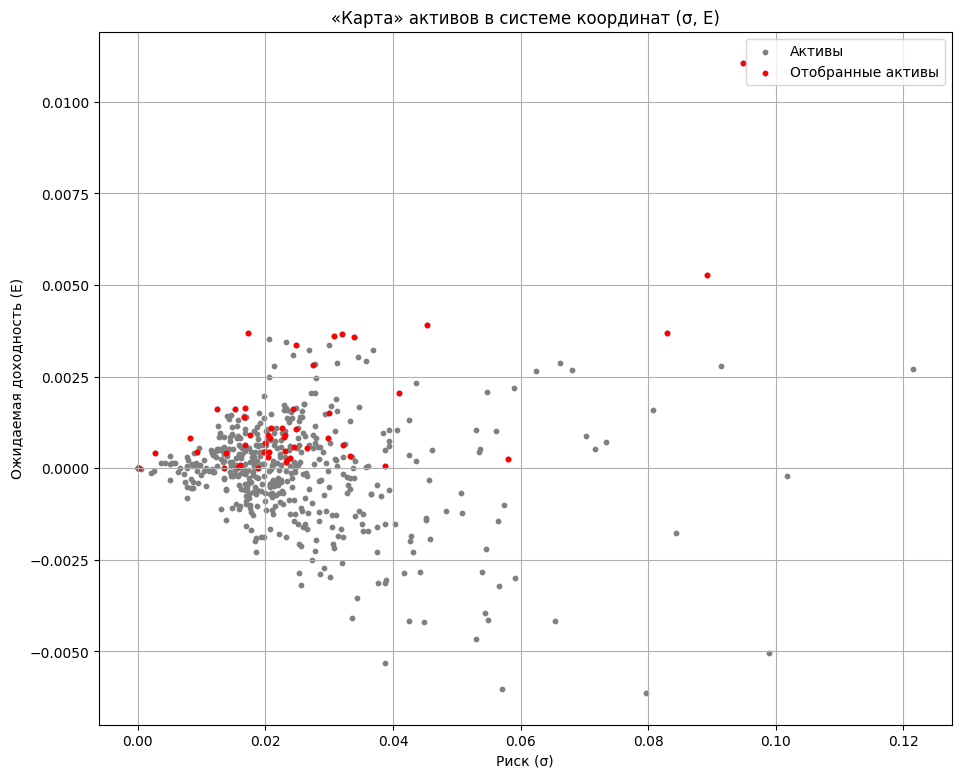

In [236]:
selected_risk_and_return = find_E_n_sigma(data, selected_tickers)

plt.figure(figsize=(11, 9))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(selected_risk_and_return['σ'], selected_risk_and_return['E'], s=10, color='red', label='Отобранные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

In [237]:
E_dict = {}
Sigma_dict = {}

for ticker in tickers:
    risk = data[ticker].std()
    E_dict[ticker] = data[ticker].mean()
    Sigma_dict[ticker] = risk
    
n_min_risk_assets = 10
weights = np.zeros(len(selected_tickers))
returns = np.zeros(len(selected_tickers))

'''_______________________________________________________________________________________

Цикл проходится по каждому выбранному тикеру, присваивая равную долю каждому активу в портфеле,
что дает равновзвешенный портфель.
_______________________________________________________________________________________'''

for i, ticker in enumerate(selected_tickers):
    weights[i] = 1 / len(selected_tickers)
    returns[i] = E_dict[ticker]

portfolio_df = pd.DataFrame({'Tickers': selected_tickers})
portfolio_df['Sigma'] = portfolio_df['Tickers'].map(Sigma_dict)
portfolio_df['Sigma_squared'] = [x*x for x in portfolio_df['Sigma']]

def portfolio_variance(weights_):
    cov_matrix = portfolio_df[['Sigma_squared']].to_numpy()
    portfolio_variance_ = weights_.T @ cov_matrix
    portfolio_variance_ = np.sum(portfolio_variance_ * weights_)
    return portfolio_variance_


- Ограничение <b>constraints_with_short_sales</b> гарантирует, что сумма долей равна 1, что позволяет осуществлять короткие продажи. При этом доли могут быть отрицательными
- <b>constraints_without_short_sales</b> также гарантирует, что сумма долей равна 1, но добавляет ограничение неравенства, чтобы гарантировать, что все доли неотрицательны, запрещая короткие продажи.

In [238]:
constraints_with_short_sales = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
)

constraints_without_short_sales = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'ineq', 'fun': lambda x: x},
)

Далее мы вычислили портфели, состоящие из 10 акций, с минимальным риском, где короткие продажи запрещены и разрешены.

Короткая продажа — это инвестиционная стратегия, при которой инвестор занимает акции и продает их на рынке с ожиданием, что цена акций упадет. Позже инвестор планирует купить акции обратно по более низкой цене, вернуть их кредитору и получить прибыль от разницы в ценах.

Для минимизации рисков мы будем использовать функцию **minimize** из scipy.optimize. Внутри неё мы используем метод **SLSQP (Sequential Least Squares Programming)**, который поддерживает как равенства, так и неравенства в ограничениях.

In [239]:
result_without_short_sales = minimize(portfolio_variance, weights, method='SLSQP', constraints=constraints_without_short_sales)
optimal_weights = result_without_short_sales.x
top_10_assets_no_short_sales = np.argsort(optimal_weights)[-n_min_risk_assets:]

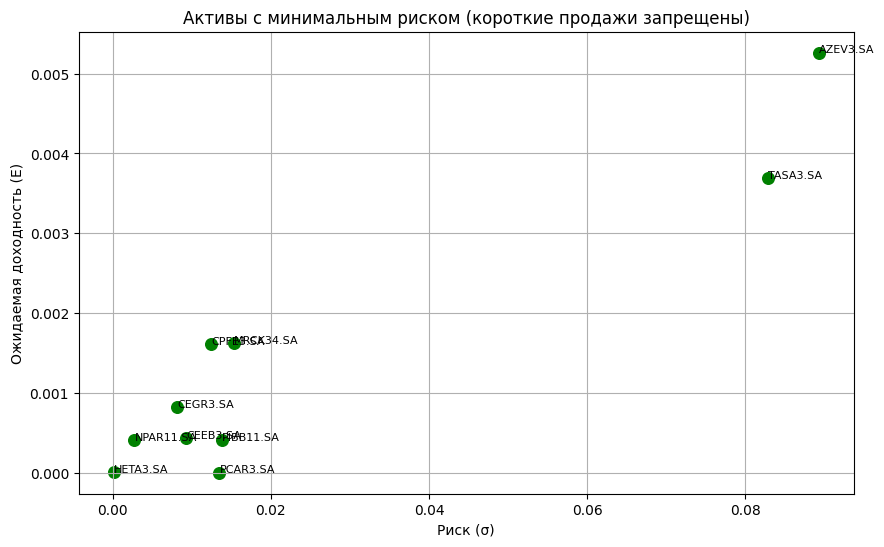

In [240]:
plt.figure(figsize=(10, 6))
for i in top_10_assets_no_short_sales:
    plt.scatter(Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]], color='green', s=70)
    plt.annotate(selected_tickers[i], (Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]]), fontsize=8)
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.title('Активы с минимальным риском (короткие продажи запрещены)')
plt.grid(True)

In [241]:
result_with_short_sales = minimize(portfolio_variance, weights, method='SLSQP', constraints=constraints_with_short_sales)
optimal_weights = result_with_short_sales.x
top_10_assets_short_sales = np.argsort(optimal_weights)[-n_min_risk_assets:]

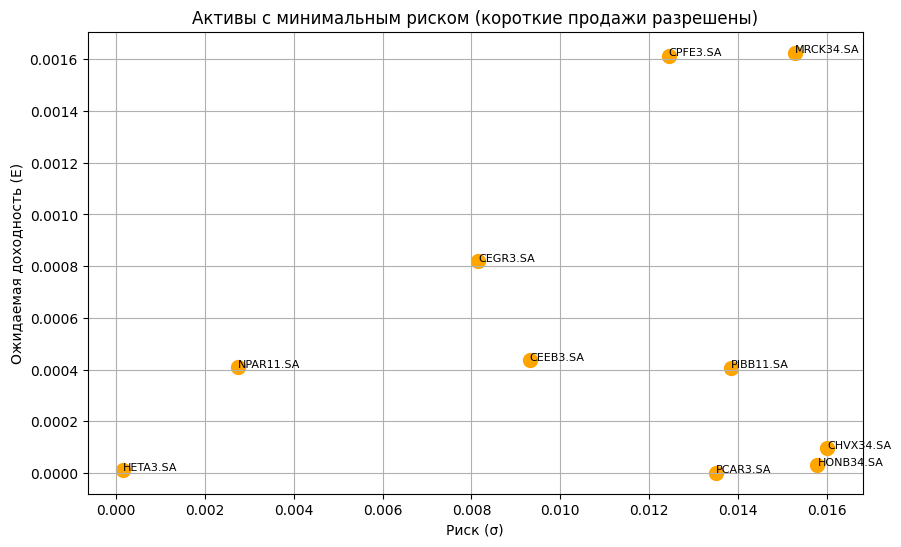

In [242]:
plt.figure(figsize=(10, 6))
for i in top_10_assets_short_sales:
    plt.scatter(Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]], color='orange', s=100)
    plt.annotate(selected_tickers[i], (Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]]), fontsize=8)
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.title('Активы с минимальным риском (короткие продажи разрешены)')
plt.grid(True)

Теперь покажем оба портфеля на одной карте для того, чтобы их можно было сравнить.

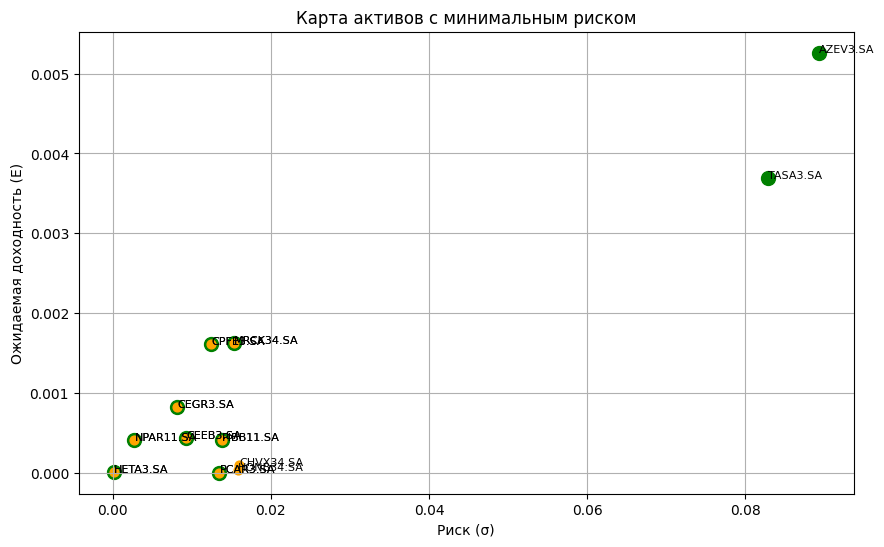

In [243]:
plt.figure(figsize=(10, 6))
for i in top_10_assets_no_short_sales:
    plt.scatter(Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]], color='green', s=100)
    plt.annotate(selected_tickers[i], (Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]]), fontsize=8)
for i in top_10_assets_short_sales:
    plt.scatter(Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]], color='orange', s=40)
    plt.annotate(selected_tickers[i], (Sigma_dict[selected_tickers[i]], E_dict[selected_tickers[i]]), fontsize=8)
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.title('Карта активов с минимальным риском')
plt.grid(True)

Большая часть активов портфелей совпадает:
- CEGR3.SA
- CPFE3.SA
- HETA3.SA
- MRCK34.SA
- NPAR11.SA
- PCAR3.SA
- CEEB3.SA
- PIBB11.SA

2 актива, где коротки продажи запрещены имеют больший риск и ожидаемую доходность, а 2 актива из другого портфеля имеют значения, близкие к основной группе активов, но при этом ожидаемая доходность практически нулевая.

# 2. Efficient frontier.
Для выбранного набора из 50 активов
- постройте эффективный фронт портфелей инвестиций с разрешением коротких продаж.
- постройте эффективный фронт портфелей с запретом коротких продаж.
- изобразите оба фронта и карту активов в системе координат (σ, E) и сравните фронты между собой.
Дайте комментарий к сравнению.
- рассмотрите портфель с равными долями вложения капитала и оцените, как далек этот портфель
от каждого из эффективных фронтов.

 Для найденного выше набора активов была построена кривая, определяющая эффективный фронт, следующим образом:

Импортирование необходимых библиотек, чтение файла с информацией об активах и инициализация матрицы ковариации с массивом средних доходостей каждого актива: 

In [ ]:
import scipy.optimize as sc
import plotly.graph_objects as go

Chosen_Tickers = ['ACNB34.SA', 'AGRO3.SA', 'ATSA11.SA', 'BAHI3.SA', 'BCRI11.SA', 'BRAX11.SA', 'COCA34.SA', 'CPFE3.SA',
                  'DHER34.SA', 'ENGI11.SA', 'EQMA3B.SA', 'ESUT11.SA', 'FISC11.SA', 'FLRP11.SA', 'FRIO3.SA', 'HFOF11.SA',
                  'ITUB3.SA', 'IVVB11.SA', 'KNHY11.SA', 'KNIP11.SA', 'MACY34.SA', 'MATB11.SA', 'MDTC34.SA', 'MRCK34.SA',
                  'MRSA3B.SA', 'PATI4.SA', 'PFIZ34.SA', 'RBRR11.SA', 'ROST34.SA', 'SUZB3.SA', 'TGAR11.SA', 'UNIP3.SA',
                  'UPAC34.SA', 'VRTA11.SA', 'WTSP11.SA', 'REDE3.SA', 'CRPG5.SA', 'CLSC4.SA', 'SNSY5.SA', 'EQPA6.SA',
                  'RSUL4.SA', 'MSPA4.SA', 'CLSC3.SA', 'DOHL4.SA', 'BSLI4.SA', 'EALT4.SA', 'BALM4.SA', 'BAUH4.SA',
                  'CTSA4.SA', 'CEED4.SA']

file_path = 'stock_data_2018.csv'
valid_tickers = []
data = []
try:
    data = pd.read_csv(file_path)
    valid_tickers = data['Ticker'].unique().tolist()
except FileNotFoundError:
    print(f"Файл {file_path} не найден. Проверьте путь к файлу.")
except pd.errors.EmptyDataError:
    print(f"Файл {file_path} пуст.")
except Exception as e:
    print(f"Произошла ошибка: {e}")

if data.empty:
    print("Файл данных пуст. Невозможно продолжить.")
    exit()

log_return = []
MeanReturns = []

for ticker in Chosen_Tickers:
    log_returns = data[data['Ticker'] == ticker]['log_return']
    MeanReturns.append(log_returns.mean())
    log_return.append(log_returns.tolist())

CovMatrix = pd.DataFrame(log_return).transpose().cov()

Целевая фукция расчёта риска и доходности в зависимости от веса

In [ ]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)
    std = np.sqrt(
            np.dot(weights.T, np.dot(covMatrix, weights))
           )
    return returns, std

функция, дающая отрицательную оценку Шарпа соответствующему активу 

In [ ]:
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd

Максимизация функции отрицательной оценки Шарпа для вычисления наиболее выгодного соотношения риска к доходности 

In [ ]:
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0, 1)):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Минимизация риска, путём оптимизирования функции риска 

In [ ]:
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]


def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Вычисление значения эффективного фронта в точке ожидаемой доходности (target) 

In [ ]:
def portfolioReturn(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]


def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0, 1)):
    
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = sc.minimize(portfolioVariance, numAssets * [1. / numAssets], args=args, method='SLSQP', bounds=bounds,
                         constraints=constraints)
    return effOpt

Комбинирование всех вышеперечисленных функций для рассчёта линии оптимального фронта, а также вычисление максимального отношения Шарпа и минимального риска текущего набора акций

In [ ]:
def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0, 1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)

    maxSR_allocation = []

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)

    minVol_allocation = []

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])

    maxSR_returns, maxSR_std = round(maxSR_returns * 100, 2), round(maxSR_std * 100, 2)
    minVol_returns, minVol_std = round(minVol_returns * 100, 2), round(minVol_std * 100, 2)

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns

Графическое представление полученных результатов

In [ ]:
def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(-1, 1)):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(
        meanReturns, covMatrix, riskFreeRate, constraintSet)

    # Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red', size=14, line=dict(width=3, color='black'))
    )

    # Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green', size=14, line=dict(width=3, color='black'))
    )

    # Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std * 100, 2) for ef_std in efficientList],
        y=[round(target * 100, 2) for target in targetReturns],
        line=dict(color='black', width=4, dash='dashdot')
    )

    data = [MaxSharpeRatio, MinVol, EF_curve]

    layout = go.Layout(
        title='Portfolio Optimisation with the Efficient Frontier',
        yaxis=dict(title='Annualised Return (%)'),
        xaxis=dict(title='Annualised Volatility (%)'),
        showlegend=True,
        legend=dict(
            x=0.75, y=0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)

    fig = go.Figure(data=data, layout=layout)
    return fig.show()

Результаты работы программы на выбранном наборе активов

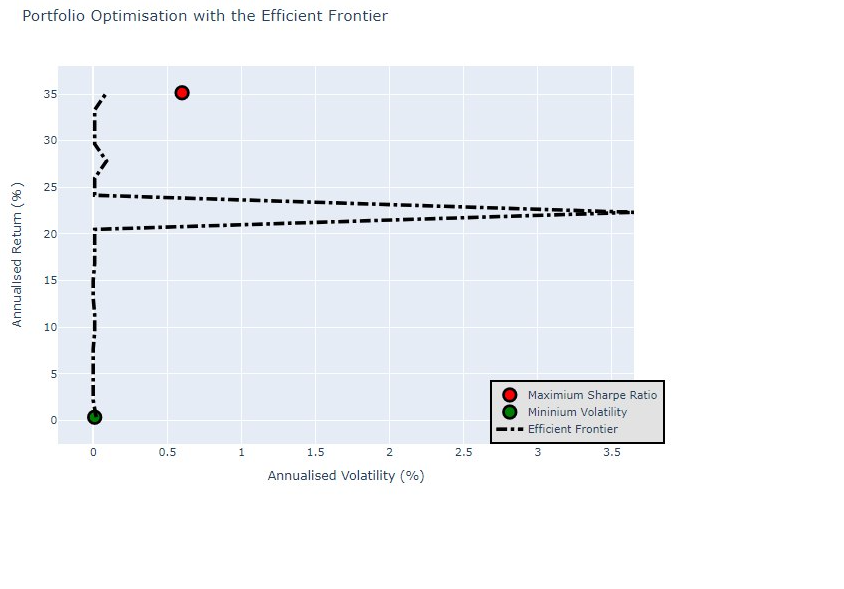

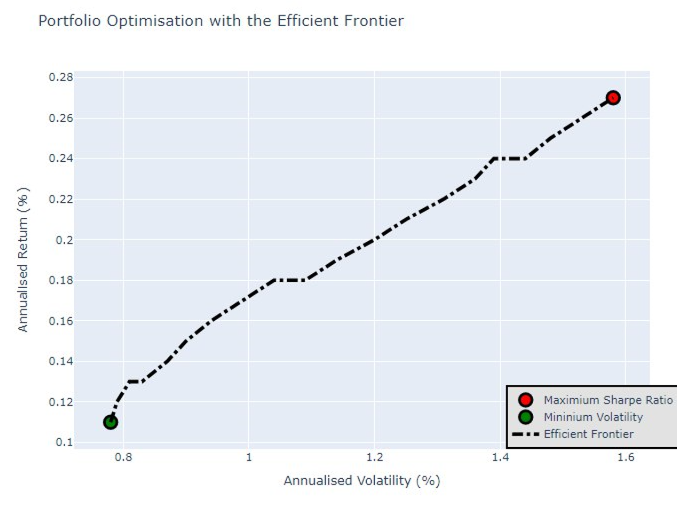

Тот же алгоритм, работающий на другом наборе активов

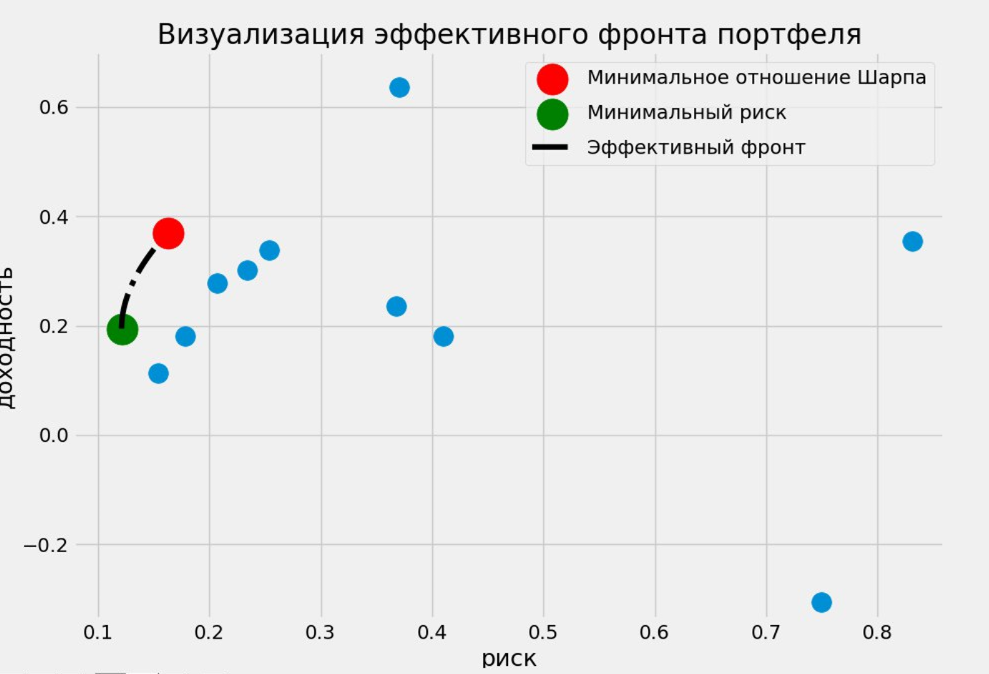

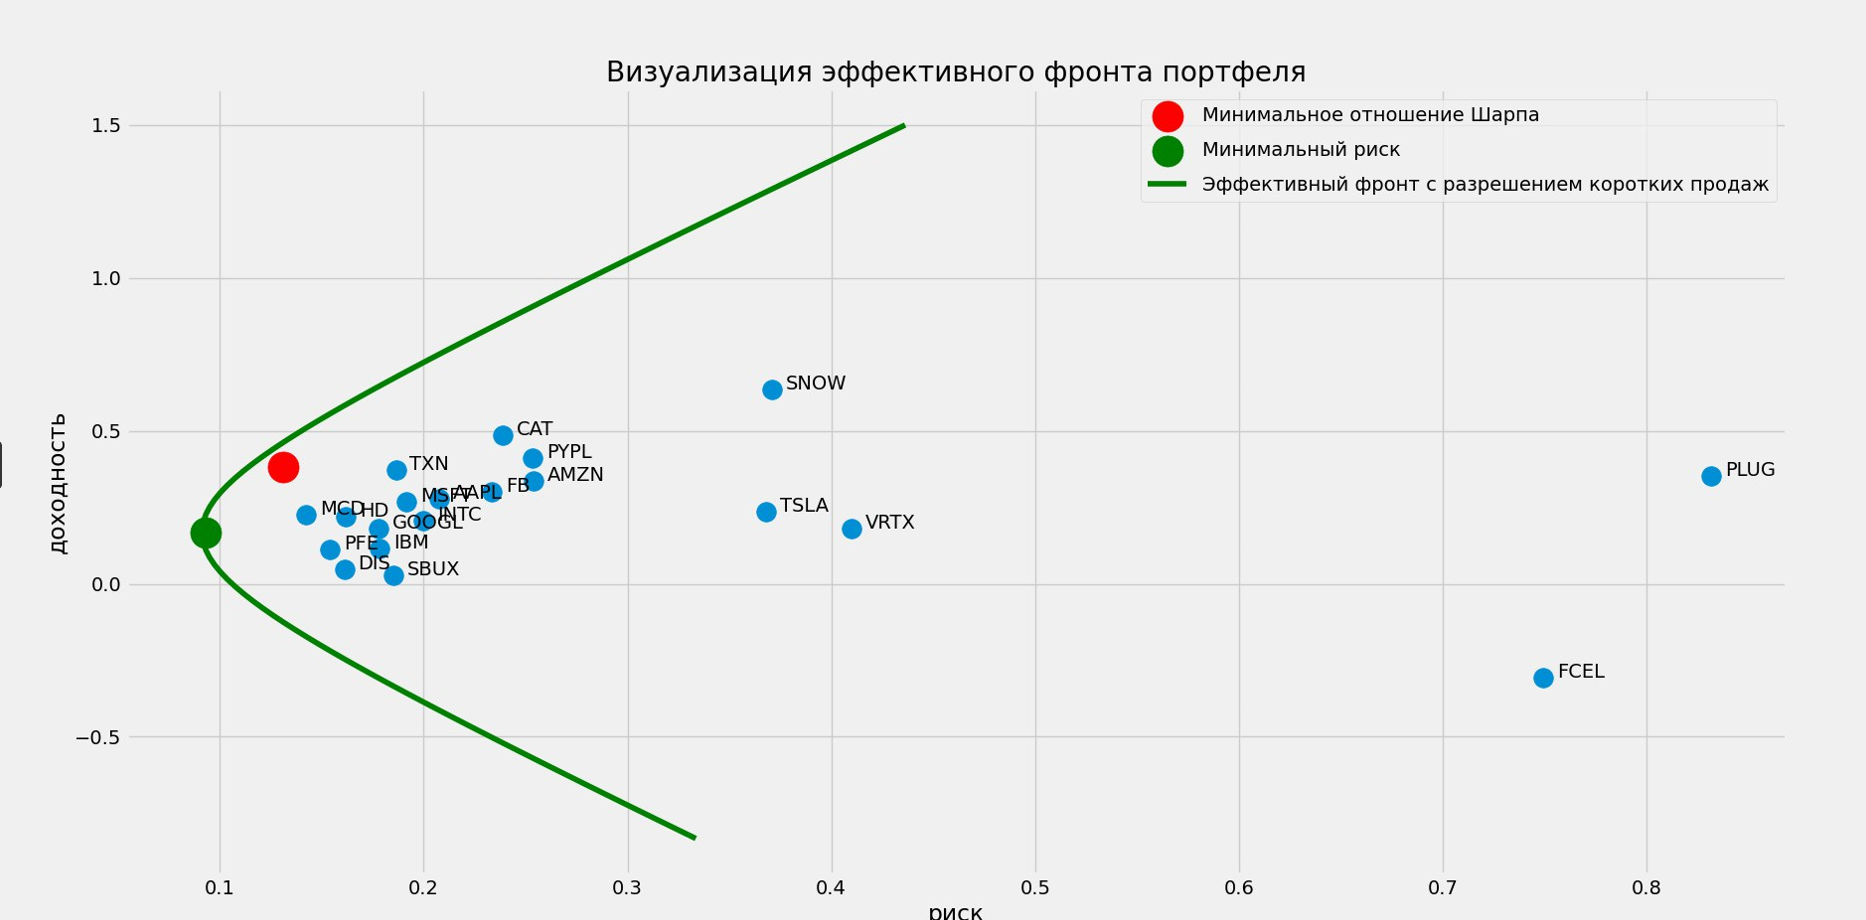

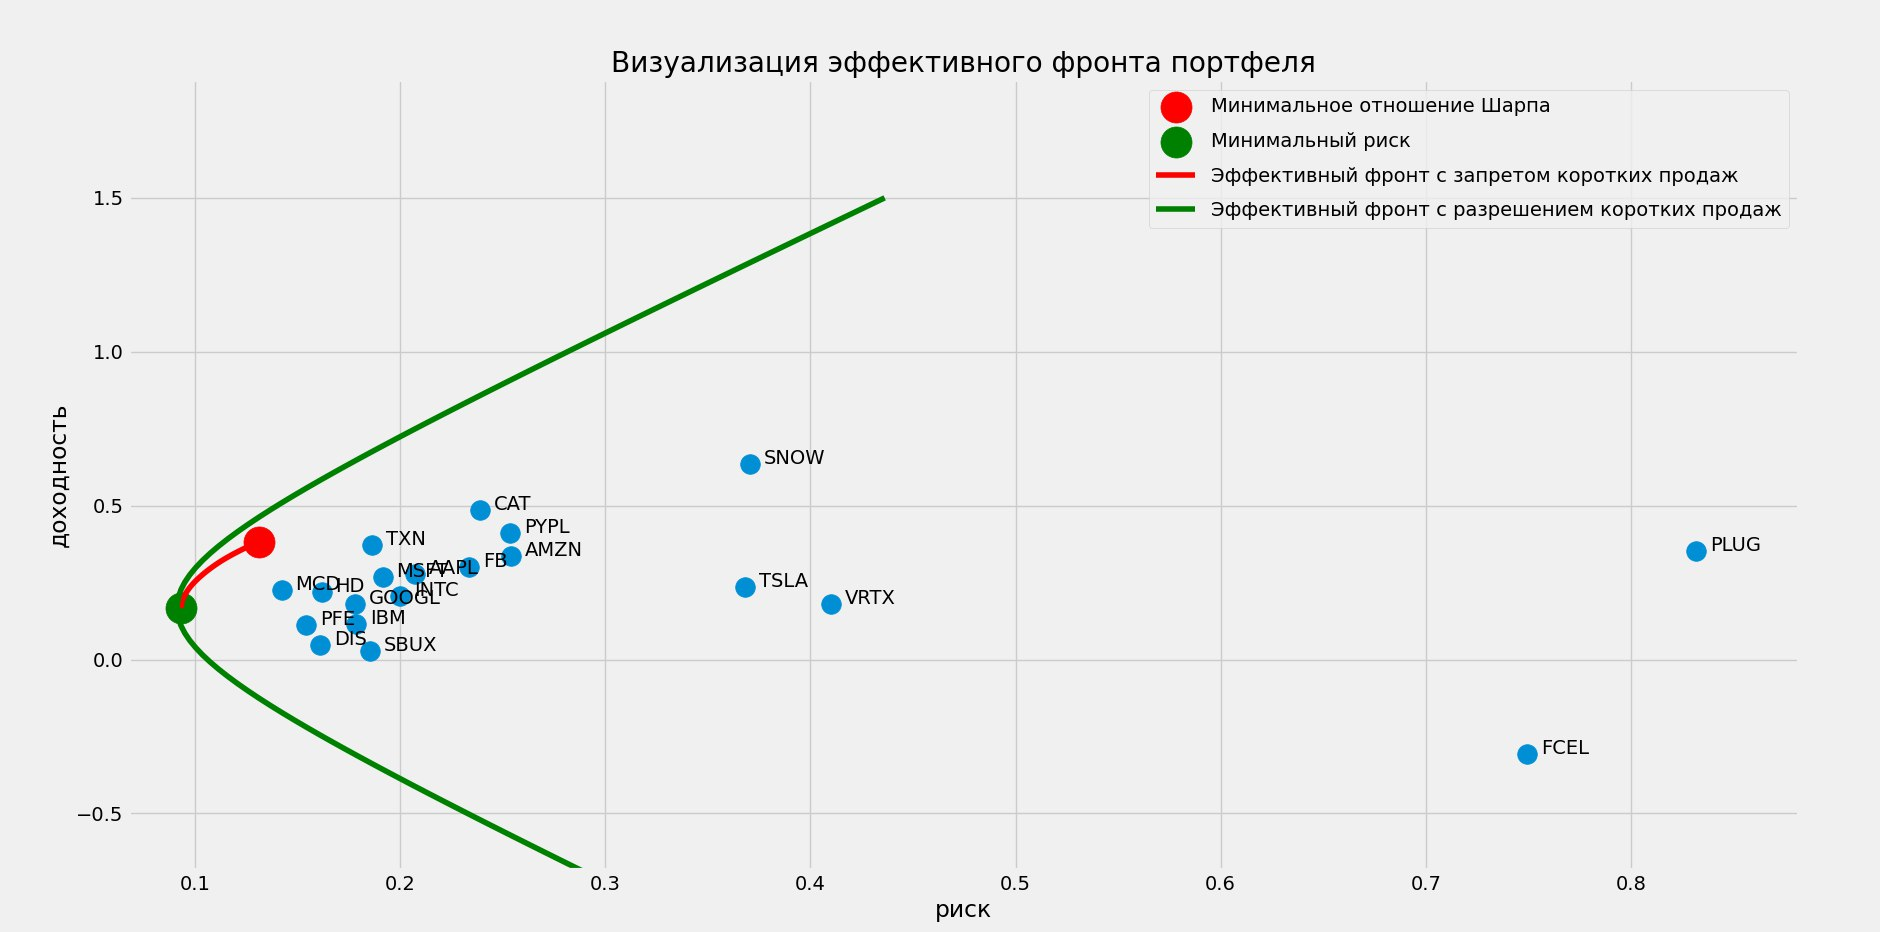

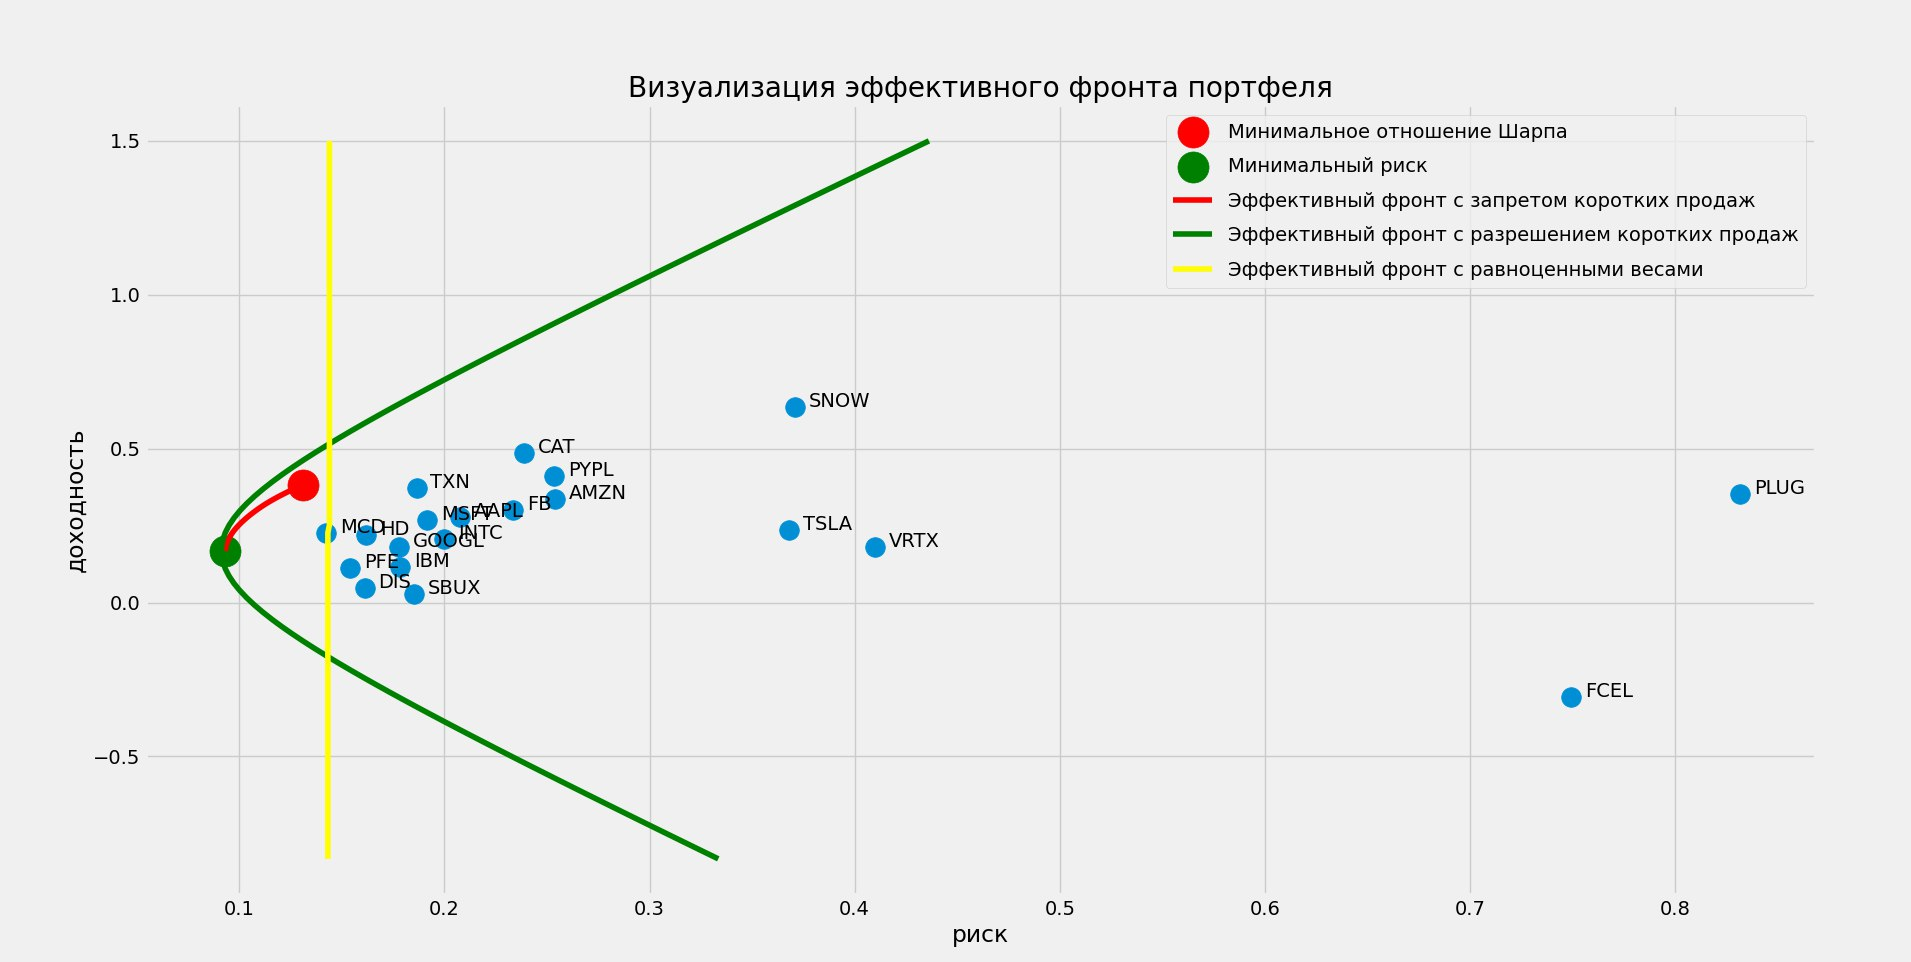

# 3. Portfolio selection problem.
Требуется построить «хорошие» инвестиционные портфели из 10
активов вместо исходных 50 (или даже всех активов рынка).
- предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля.
- сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций)
для случая, когда короткие продажи разрешены. Дайте комментарий.
- сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций)
для случая, когда короткие продажи запрещены. Дайте комментарий.

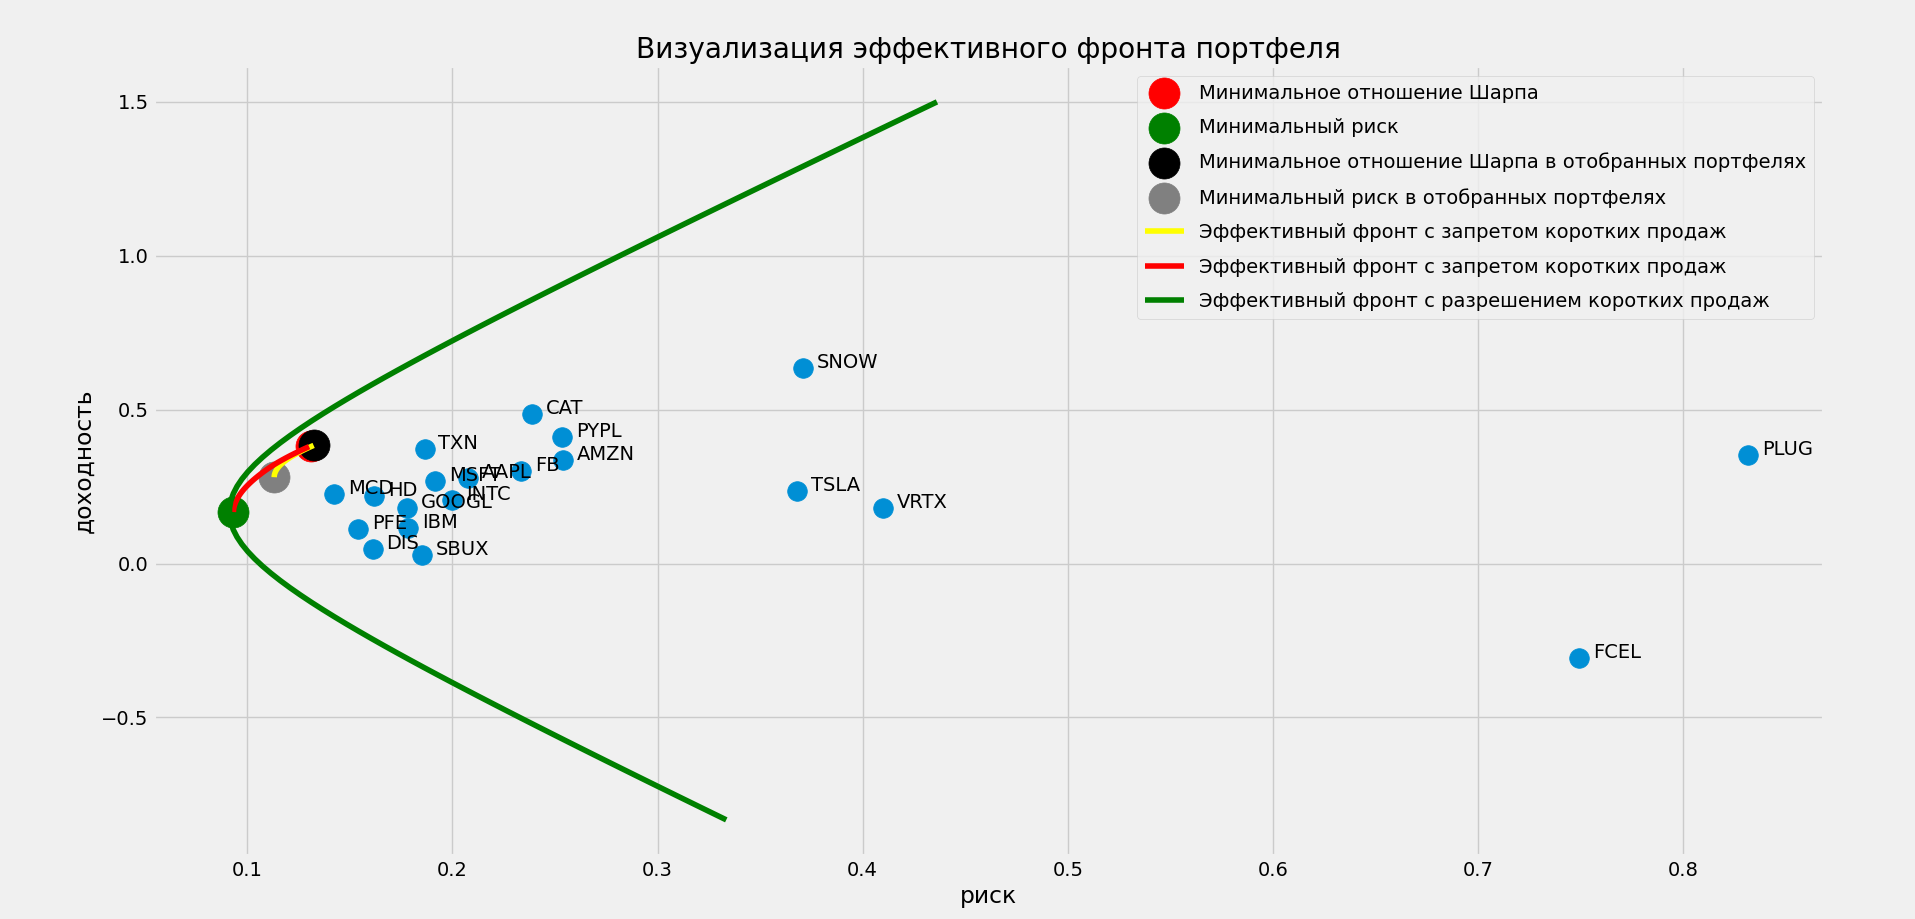

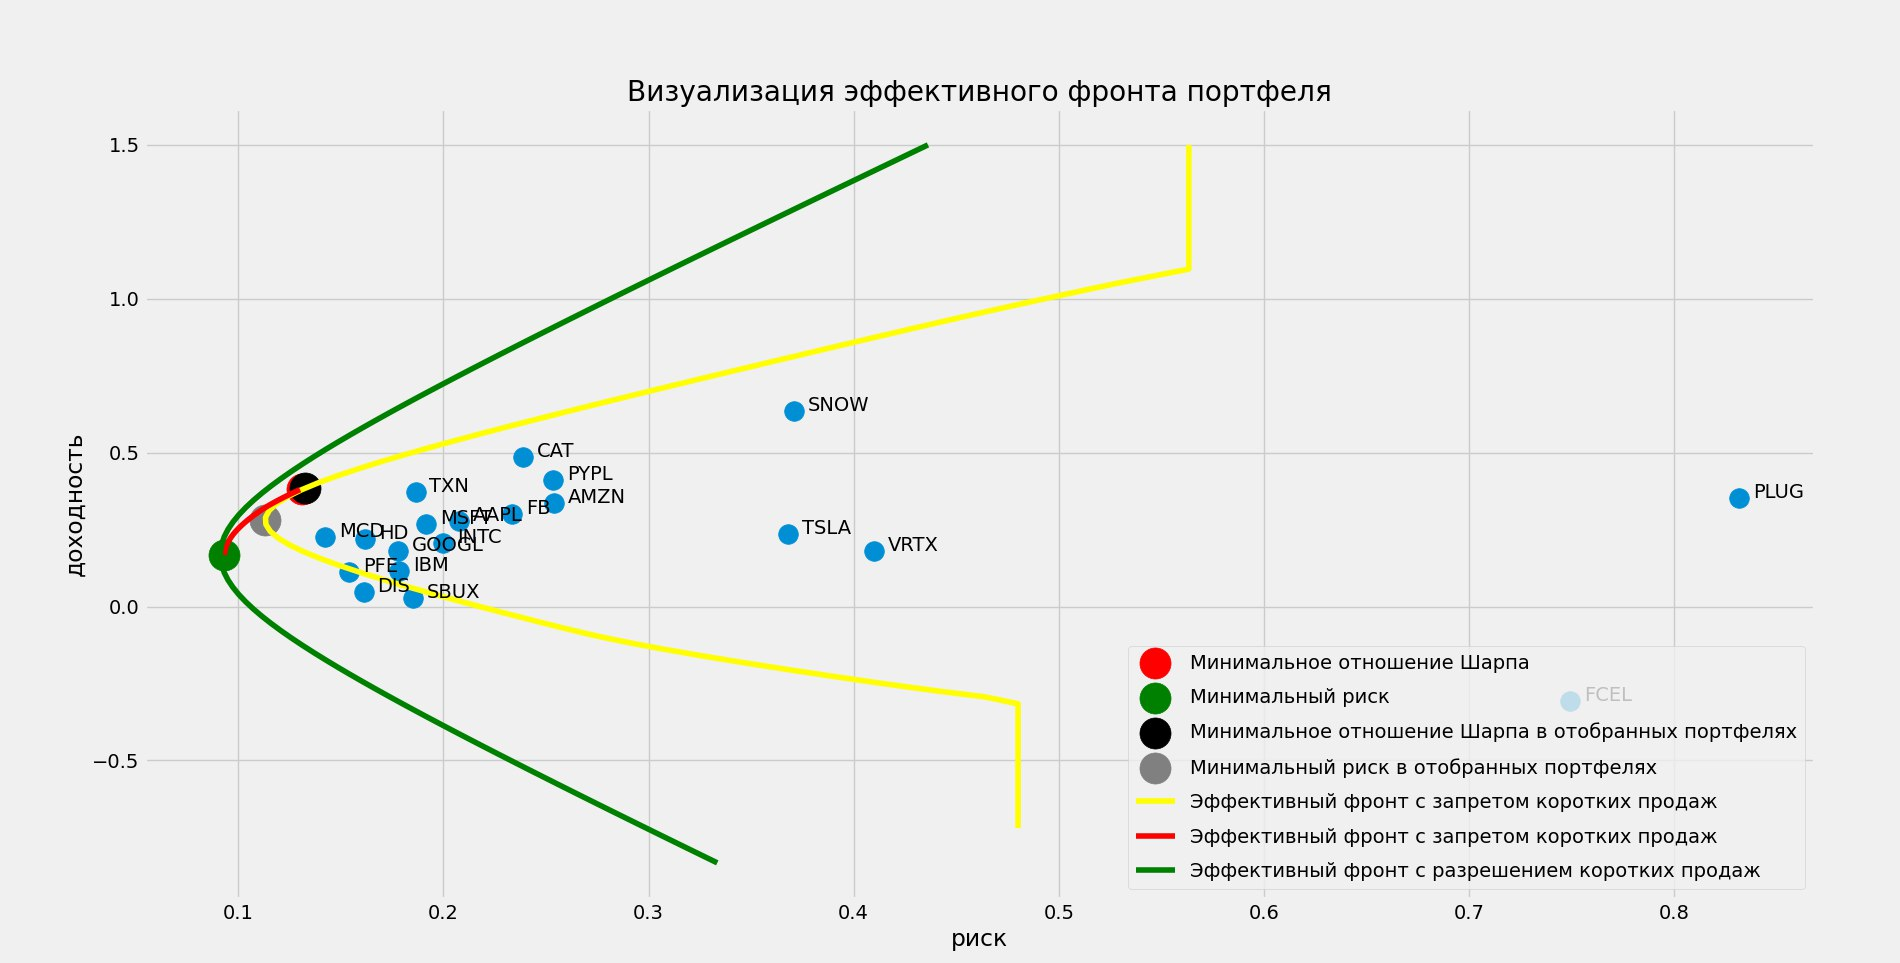

# 3. Portfolio selection problem.
Требуется построить «хорошие» инвестиционные портфели из 10
активов вместо исходных 50 (или даже всех активов рынка).
- предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля.
- сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций)
для случая, когда короткие продажи разрешены. Дайте комментарий.
- сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций)
для случая, когда короткие продажи запрещены. Дайте комментарий.

# 4. Risk aversion.
- Оцените свое отношение к риску.
- для выбранного отношения к риску постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов в случае, когда короткие продажи разрешены. Дайте характеристику портфеля по составу и долям активов.
- оцените VaR и CvaR доходностей этого портфеля. В системе координат (σ, E) изобразите эффективный фронт и ваш оптимальный портфель.
- для выбранного отношения к риску постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов в случае, когда короткие продажи запрещены. Дайте характеристику портфеля по составу и долям активов.
- оцените VaR и CVaR доходностей этого портфеля. В системе координат (σ, E) изобразите эффективный фронт и ваш оптимальный портфель.

<p>
Чаще всего для обозначения коэффициента отношения к риску используются значения в диапазоне от 1 до 3, где 1 — риск не важен, 3 — минимизирование риска. Так как мы не опытны в торговле акциями, то предпочтём избегать риск и выберем <b>risk_aversion = 3</b>
</p>

<p>
Сначала все активы в нашем портфеле имеют одинаковые доли. Далее с помощью функции <b>minimize</b> мы проверяем различные варианты долей акций и находим <b>γ*σ(x) - E(x) --> min</b>
</p>

In [255]:
risk_aversion = 3

# Подсчет формулы γ*σ(x) - E(x)
def objective_function(weights):
    portfolio_sigma = np.dot(weights, selected_risk_and_return['σ'])
    portfolio_return = np.dot(weights, selected_risk_and_return['E'])
    result = risk_aversion * portfolio_sigma - portfolio_return
    return result

# Оптимизация путем перебора различных вариантов долей в портфеле
def optimization(bound, constraints_):
    initial_weights = np.array([1/len(selected_tickers)] * len(selected_tickers))

    bounds = [(bound, None) for _ in range(len(selected_tickers))]
    
    result = minimize(objective_function, initial_weights, method='SLSQP', constraints=constraints_, bounds=bounds)
    optimal_weights = result.x

    portfolio = pd.DataFrame({'Ticker': selected_tickers, 'Weight': optimal_weights})
    portfolio = portfolio[portfolio['Weight'] != 0]

    return portfolio

# Подсчет количества акций для коротких и длительных продаж
def count_sales(portfolio):
    long_sales = 0
    short_sales = 0

    for i in portfolio['Weight']:
        if i > 0:
            long_sales += 1
        else:
            short_sales += 1
    
    result = f'''
    ==============================
    Длительные продажи: {long_sales} акций
    Короткие продажи: {short_sales} акций
    ==============================
    '''
    return result

Первым построим оптимальный портфель инвестиций в случае, когда короткие продажи разрешены.

In [256]:
portfolio_with_short_sales = optimization(None, constraints_with_short_sales)

print(count_sales(portfolio_with_short_sales))
print(portfolio_with_short_sales)


    Длительные продажи: 35 акций
    Короткие продажи: 15 акций
    
       Ticker        Weight
0    AZEV3.SA -6.179232e+07
1    CEGR3.SA  1.861622e+07
2    CPFE3.SA  1.456402e+07
3    EQPA6.SA -6.543969e+07
4    HETA3.SA  2.641710e+07
5    IRBR3.SA  1.044191e+07
6   LILY34.SA  1.008626e+07
7    LOGN3.SA -1.794659e+07
8   MRCK34.SA  1.169601e+07
9   NPAR11.SA  2.393797e+07
10   HBTS5.SA -3.191880e+07
11   TASA3.SA -5.591615e+07
12   CEBR6.SA  3.671238e+06
13  TSLA34.SA -5.679382e+06
14  MOSC34.SA  5.885905e+06
15   EMBR3.SA  2.957238e+06
16   TUPY3.SA  6.102993e+06
17  HONB34.SA  1.065010e+07
18   PCAR3.SA  1.295297e+07
19  NFLX34.SA -3.256211e+06
20   UNIP5.SA -4.563543e+06
21  ABBV34.SA  3.228936e+06
22   RAIL3.SA  4.073034e+06
23  COPH34.SA  6.195602e+06
24   WLMM4.SA -1.260405e+07
25   ESTR4.SA  6.757237e+06
26   UNIP3.SA -3.310086e+06
27   UNIP6.SA -6.369528e+06
28   VALE3.SA  5.975153e+06
29   GGBR3.SA  3.514613e+06
30   BRSR6.SA  2.590685e+06
31   CEEB3.SA  1.732527e+07
32   T

Размер долей колеблется примерно от -65439693.80209317 до 26417102.993436664. В нашем портфеле 15 акций имеют долю меньше нуля и 35 акций имеют долю больше нуля.
Когда доля актива в портфеле меньше нуля, это означает, что в портфеле используется короткая продажа этого актива.

В данном портфеле <b>γ*σ(x) - E(x) = -50059484.1318997</b>

Теперь оценим VaR и CVaR доходностей этого портфеля.

In [288]:
def make_returns(portfolio):
    portfolio_returns = pd.DataFrame()
    ticker_returns = pd.DataFrame()

    for ticker in portfolio['Ticker']:
        ticker_returns['log_return'] = pd.DataFrame(data[ticker]).reset_index(drop=True)
        portfolio_returns[ticker] = ticker_returns['log_return']
    portfolio_returns['Portfolio Returns'] = portfolio_returns.sum(axis=1)
    
    return portfolio_returns['Portfolio Returns']

def historicalVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [289]:
portfolio_ = make_returns(portfolio_with_short_sales)
VaR = -historicalVaR(portfolio_, 5)
CVaR = -historicalCVaR(portfolio_, 5)

print(f'VaR:  {VaR}, \nCVaR: {CVaR}')

VaR:  0.5600424616498144, 
CVaR: 0.6847413459618016


Портфель демонстрирует значительные риски. В условиях негативного сценария, когда потери превышают VaR, они могут быть чрезвычайно большими, что подчеркивает необходимость более тщательного управления рисками.

In [290]:
log_return = []
MeanReturns = []

for ticker in tickers:
    log_returns = data[ticker]
    MeanReturns.append(log_returns.mean())
    log_return.append(log_returns.tolist())

CovMatrix = pd.DataFrame(log_return).transpose().cov()

Теперь построим оптимальный портфель инвестиций в случае, когда короткие продажи запрещены.

In [291]:
portfolio_without_short_sales = optimization(0, constraints_without_short_sales)

print(count_sales(portfolio_without_short_sales))
print(portfolio_without_short_sales)


    Длительные продажи: 26 акций
    Короткие продажи: 0 акций
    
       Ticker        Weight
1    CEGR3.SA  7.502112e-16
2    CPFE3.SA  6.698501e-16
3    EQPA6.SA  1.917839e-17
4    HETA3.SA  1.000000e+00
5    IRBR3.SA  2.837619e-16
6   LILY34.SA  4.467296e-16
9   NPAR11.SA  1.110223e-15
10   HBTS5.SA  1.095475e-16
11   TASA3.SA  2.668608e-16
14  MOSC34.SA  1.349857e-17
16   TUPY3.SA  2.731891e-18
17  HONB34.SA  1.805930e-16
20   UNIP5.SA  1.555783e-17
22   RAIL3.SA  2.449653e-17
23  COPH34.SA  2.763900e-17
31   CEEB3.SA  6.801319e-17
32   TAEE4.SA  3.846514e-17
34  MSFT34.SA  2.698784e-16
35   GGBR4.SA  5.403178e-17
36  ITLC34.SA  3.965361e-17
37   BRAP3.SA  4.131828e-17
38   EALT4.SA  2.353767e-17
45  PIBB11.SA  1.040492e-16
47  GILD34.SA  1.442597e-16
48  BPAC11.SA  5.032471e-16
49   ITUB3.SA  2.355537e-16


Доля принимает значения от -65439693.80209317 до 26417102.993436664. В отличие от случая, когда короткие продажи разрешены, в этом портфеле всего 26 акций. <b>γ*σ(x) - E(x) = 0.0004683795709621211</b>. Как мы видим, в данном портфеле нет коротких продаж, как и должно быть.

In [292]:
portfolio_ = make_returns(portfolio_without_short_sales)
VaR = -historicalVaR(portfolio_, 5)
CVaR = -historicalCVaR(portfolio_, 5)

print(f'VaR:  {VaR}, \nCVaR: {CVaR}')

VaR:  0.28317033188567764, 
CVaR: 0.3793161123423929
